In [53]:
import pandas as pd
import numpy as np

# Load crop dataset
df_crop = pd.read_csv('crop1.csv')

print("First few rows:")
print(df_crop.head())
print("\n" + "="*50 + "\n")

print("Dataset shape:")
print(f"Rows: {df_crop.shape[0]}, Columns: {df_crop.shape[1]}")
print("\n" + "="*50 + "\n")

print("Crop types in dataset:")
print(df_crop['Item'].value_counts())
print()

print("Measurement elements:")
print(df_crop['Element'].value_counts())
print()

print("Year range coverage:")
print(f"Data spans from {df_crop['Year'].min()} to {df_crop['Year'].max()}")
print(f"Total years covered: {df_crop['Year'].max() - df_crop['Year'].min() + 1}")
print()

print("Unit types:")
print(df_crop['Unit'].value_counts())
print()

print("Value statistics by Element type:")
for element in df_crop['Element'].unique():
    element_data = df_crop[df_crop['Element'] == element]['Value'].dropna()
    if len(element_data) > 0:
        print(f"\n{element}:")
        print(f"  Count: {len(element_data)}")
        print(f"  Mean: {element_data.mean():.2f}")
        print(f"  Min: {element_data.min()}")
        print(f"  Max: {element_data.max()}")
        print(f"  Unit: {df_crop[df_crop['Element'] == element]['Unit'].iloc[0]}")



First few rows:
          Area                 Item         Element  Year Unit   Value
0  Afghanistan  Almonds, with shell  Area harvested  1975   ha     0.0
1  Afghanistan  Almonds, with shell  Area harvested  1976   ha  5900.0
2  Afghanistan  Almonds, with shell  Area harvested  1977   ha  6000.0
3  Afghanistan  Almonds, with shell  Area harvested  1978   ha  6000.0
4  Afghanistan  Almonds, with shell  Area harvested  1979   ha  6000.0


Dataset shape:
Rows: 1895975, Columns: 6


Crop types in dataset:
Item
Vegetables, fresh nes    38635
Maize                    33379
Tomatoes                 33326
Potatoes                 31597
Fruit, fresh nes         31485
                         ...  
Cinnamon (cannella)       4238
Cloves                    4070
Tung nuts                 3338
Ramie                     2943
Tallowtree seed            774
Name: count, Length: 118, dtype: int64

Measurement elements:
Element
Production        663735
Area harvested    656510
Yield             575730

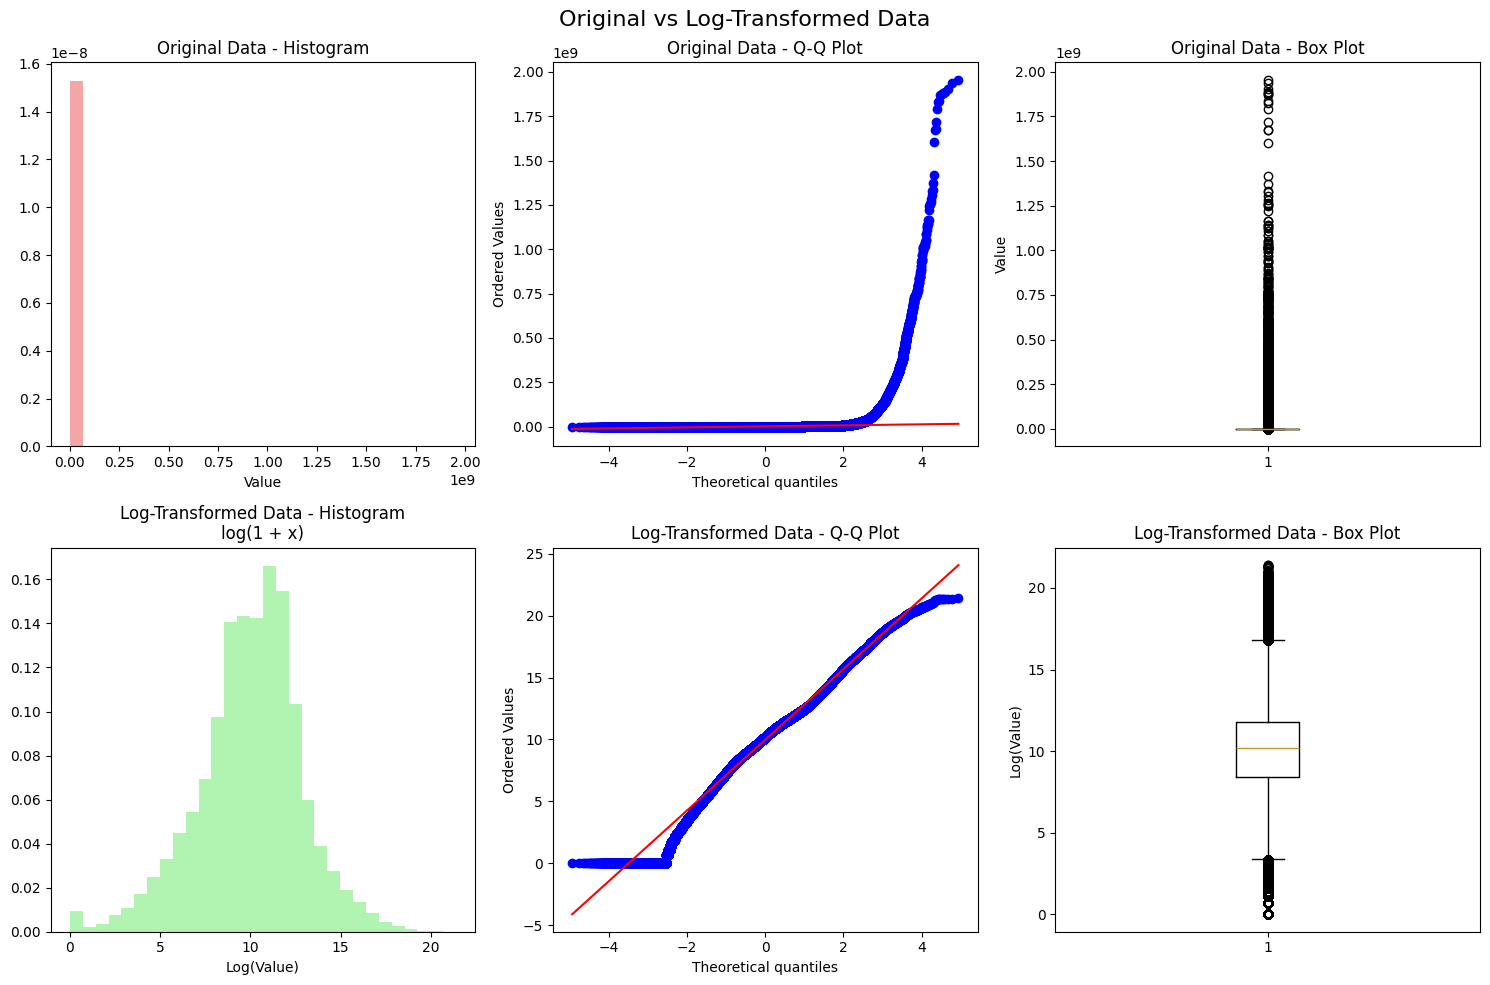

In [31]:
# Test log transformation to achieve normality
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load data
df_crop = pd.read_csv('crop1.csv')

# Remove missing values
values = df_crop['Value'].dropna()

# Use log(x + 1) to handle zeros
values_log = np.log1p(values)  
transform_name = "log(1 + x)"

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Original vs Log-Transformed Data', fontsize=16)

# Original data plots
axes[0, 0].hist(values, bins=30, density=True, alpha=0.7, color='lightcoral')
axes[0, 0].set_title('Original Data - Histogram')
axes[0, 0].set_xlabel('Value')

stats.probplot(values, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Original Data - Q-Q Plot')

axes[0, 2].boxplot(values)
axes[0, 2].set_title('Original Data - Box Plot')
axes[0, 2].set_ylabel('Value')

# Log-transformed data plots
axes[1, 0].hist(values_log, bins=30, density=True, alpha=0.7, color='lightgreen')
axes[1, 0].set_title(f'Log-Transformed Data - Histogram\n{transform_name}')
axes[1, 0].set_xlabel('Log(Value)')

stats.probplot(values_log, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title(f'Log-Transformed Data - Q-Q Plot')

axes[1, 2].boxplot(values_log)
axes[1, 2].set_title('Log-Transformed Data - Box Plot')
axes[1, 2].set_ylabel('Log(Value)')

plt.tight_layout()
plt.show()




In [40]:
df_crop = pd.read_csv('crop1.csv')


print("Unique values in categorical columns:")
for col in df_crop.select_dtypes(include=['object']).columns:
    unique_count = df_crop[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {df_crop[col].unique()}")
    else:
        print(f"  Sample values: {df_crop[col].unique()[:10]}")
    print()

Unique values in categorical columns:
Area: 245 unique values
  Sample values: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan']

Item: 118 unique values
  Sample values: ['Almonds, with shell' 'Anise, badian, fennel, coriander' 'Apples'
 'Apricots' 'Barley' 'Berries nes' 'Figs' 'Fruit, citrus nes'
 'Fruit, fresh nes' 'Fruit, stone nes']

Element: 3 unique values
  Values: ['Area harvested' 'Yield' 'Production']

Unit: 3 unique values
  Values: ['ha' 'hg/ha' 'tonnes']



In [57]:
print("Missing values:")
missing_values = df_crop.isnull().sum()
total_rows = len(df_crop)
for col, missing_count in missing_values.items():
    percentage = (missing_count / total_rows) * 100
    print(f"{col}: {missing_count} ({percentage:.1f}%)")

Missing values:
Area: 0 (0.0%)
Item: 0 (0.0%)
Element: 0 (0.0%)
Year: 0 (0.0%)
Unit: 0 (0.0%)
Value: 129500 (6.8%)


In [75]:
print("outlier rows:")

def detect_outliers_log_zscore_fast(data, threshold=3):
    clean_data = data.dropna()
    if len(clean_data) == 0:
        return pd.Index([])
    
    log_values = np.log1p(clean_data)
    z_scores = np.abs((log_values - log_values.mean()) / log_values.std())
    return clean_data.index[z_scores > threshold]

all_outlier_indices = set()

for element in df_crop['Element'].unique():
    element_mask = df_crop['Element'] == element
    element_data = df_crop.loc[element_mask, 'Value']
    outlier_indices = detect_outliers_log_zscore_fast(element_data)
    all_outlier_indices.update(outlier_indices)

# Remove only the actual outlier rows
df_crop_clean = df_crop.drop(index=list(all_outlier_indices))

# Show results
print(f"Original dataset: {len(df_crop)} rows")
print(f"Outlier rows: {len(all_outlier_indices)}")
print(f"Clean dataset: {len(df_crop_clean)} rows")
print(f"Percentage removed if we remove: {len(all_outlier_indices)/len(df_crop)*100:.2f}%")


# Reset index for clean dataset
df_crop_clean = df_crop_clean.reset_index(drop=True)

outlier rows:
Original dataset: 1895975 rows
Outlier rows: 7629
Clean dataset: 1888346 rows
Percentage removed if we remove: 0.40%


In [67]:
# Missing values per country
print("Missing values per country:")

# Find missing rows
missing_rows = df_crop[df_crop['Value'].isnull()]

# Count missing values by country
missing_by_country = missing_rows['Area'].value_counts()

print(f"Countries with missing data: {len(missing_by_country)}")
print(f"Total missing values: {missing_by_country.sum()}")
print()

# Show top 20 countries with most missing data
print("Top 20 countries with most missing values:")
for i, (country, count) in enumerate(missing_by_country.head(20).items(), 1):
    percentage = (count / len(df_crop[df_crop['Area'] == country])) * 100
    print(f"{i:2}. {country:<35} {count:>5} missing ({percentage:.1f}%)")

# Show countries with no missing data
all_countries = set(df_crop['Area'].unique())
countries_with_missing = set(missing_by_country.index)
complete_countries = all_countries - countries_with_missing

print(f"\nCountries with NO missing data ({len(complete_countries)}):")
for country in sorted(complete_countries):
    print(f"- {country}")

Missing values per country:
Countries with missing data: 237
Total missing values: 129500

Top 20 countries with most missing values:
 1. Palestine                            4496 missing (47.6%)
 2. Albania                              2234 missing (25.5%)
 3. Nepal                                1963 missing (24.2%)
 4. Colombia                             1889 missing (17.1%)
 5. Bhutan                               1858 missing (28.5%)
 6. Romania                              1689 missing (15.6%)
 7. Kenya                                1662 missing (12.8%)
 8. China, mainland                      1622 missing (8.2%)
 9. Guyana                               1621 missing (25.8%)
10. Switzerland                          1618 missing (18.6%)
11. Costa Rica                           1528 missing (19.0%)
12. Malta                                1501 missing (24.7%)
13. Poland                               1474 missing (16.9%)
14. Belize                               1471 missing (27.6%)

In [70]:
print("Missing data for Afghanistan:")

missing_rows = df_crop[df_crop['Value'].isnull()]

afghanistan_missing = missing_rows[missing_rows['Area'] == 'Afghanistan']

if len(afghanistan_missing) > 0:
    print(f"Afghanistan has {len(afghanistan_missing)} missing values")
    
    missing_years = sorted(afghanistan_missing['Year'].unique())
    print("Years with missing data:")
    for year in missing_years:
        print(f"- {year}")
    
    if missing_years:
        print(f"\nFirst missing year: {missing_years[0]}")
        print(f"Last missing year: {missing_years[-1]}")


        


Missing data for Afghanistan:
Afghanistan has 98 missing values
Years with missing data:
- 1961
- 1962
- 1963
- 1964
- 1965
- 1966
- 1967
- 1968
- 1969
- 1970
- 1971
- 1972
- 1973
- 1974
- 1975
- 1976
- 1977
- 1978
- 1979
- 1980
- 1981
- 1982
- 1983
- 1984
- 1985
- 1991
- 1992
- 1993
- 1994
- 1995
- 1996
- 1997
- 1998
- 1999
- 2000
- 2001
- 2002
- 2003
- 2004
- 2005
- 2006
- 2007
- 2008
- 2009
- 2010
- 2011
- 2012
- 2013
- 2014

First missing year: 1961
Last missing year: 2014


In [66]:
# Remove rows with missing values
df_crop_clean = df_crop.dropna(subset=['Value'])

print(f"Original dataset: {len(df_crop):,} rows")
print(f"Rows with missing values: {df_crop['Value'].isnull().sum():,}")
print(f"Clean dataset: {len(df_crop_clean):,} rows")
print(f"Percentage removed: {(df_crop['Value'].isnull().sum()/len(df_crop)*100):.1f}%")

Original dataset: 1,895,975 rows
Rows with missing values: 129,500
Clean dataset: 1,766,475 rows
Percentage removed: 6.8%


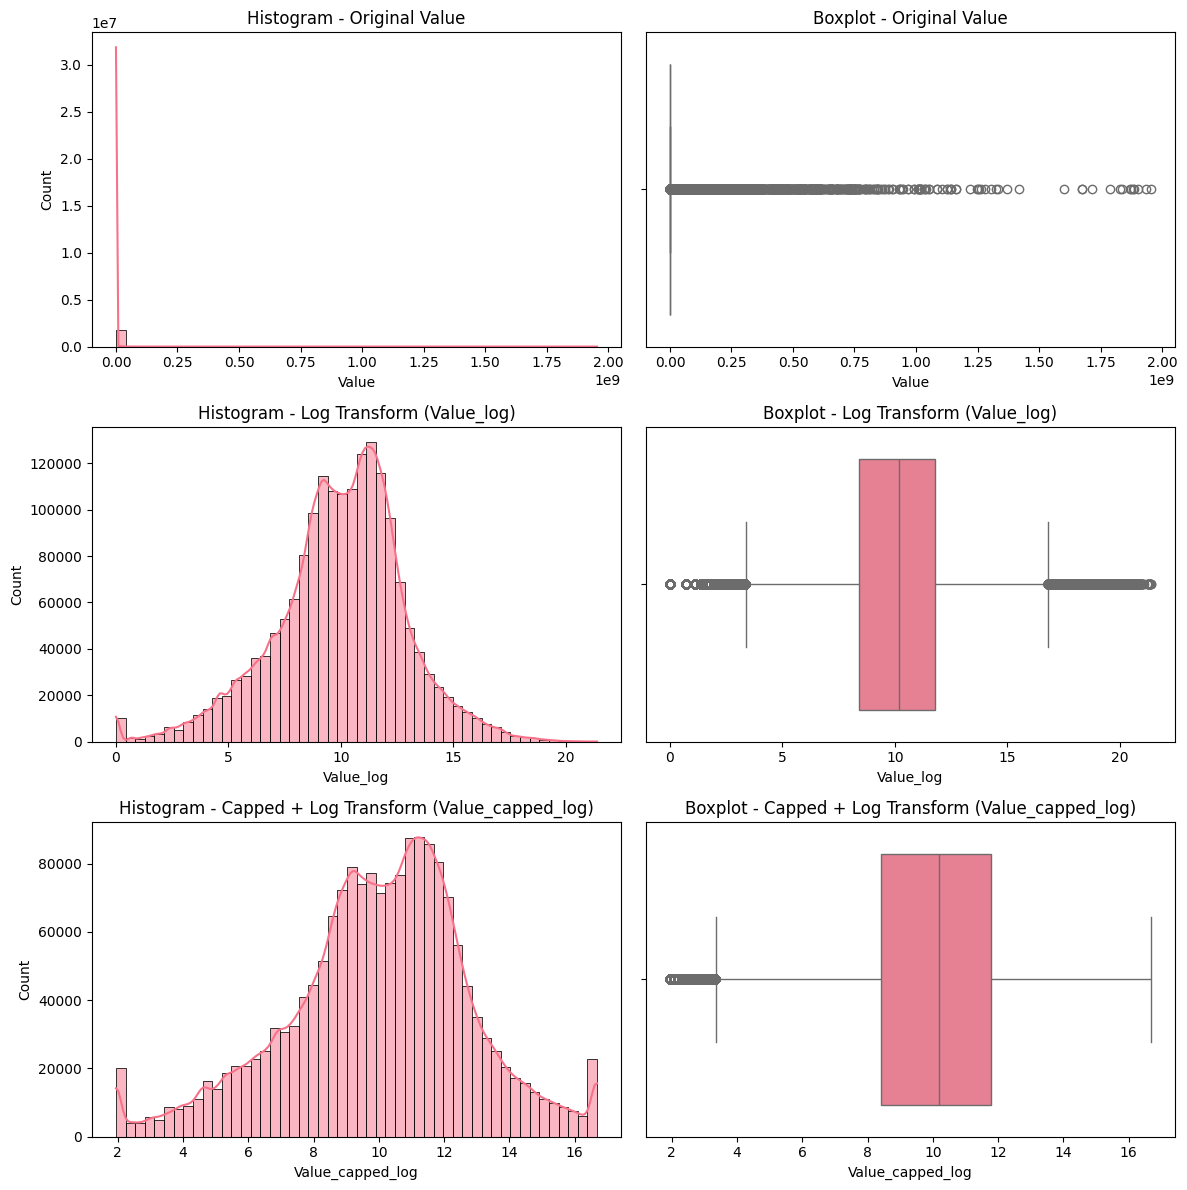

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def cap_and_log_transform(df, column, lower_quantile=0.01, upper_quantile=0.99):
    """
    Cap values at given quantiles and apply log-transform (log1p).
    """
    lower_cap = df[column].quantile(lower_quantile)
    upper_cap = df[column].quantile(upper_quantile)
    capped = df[column].clip(lower=lower_cap, upper=upper_cap)
    transformed = np.log1p(capped)
    return transformed

def log_transform(df, column):
    """
    Simple log-transform without capping.
    """
    return np.log1p(df[column])

def plot_comparison(df, original, log_col, capped_log_col):
    """
    Plot histograms and boxplots for original, log-only, and capped+log data.
    """
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # Histogram original
    sns.histplot(df[original].dropna(), bins=50, ax=axes[0,0], kde=True)
    axes[0,0].set_title(f"Histogram - Original {original}")
    
    # Boxplot original
    sns.boxplot(x=df[original].dropna(), ax=axes[0,1])
    axes[0,1].set_title(f"Boxplot - Original {original}")

    # Histogram log-only
    sns.histplot(df[log_col].dropna(), bins=50, ax=axes[1,0], kde=True)
    axes[1,0].set_title(f"Histogram - Log Transform ({log_col})")
    
    # Boxplot log-only
    sns.boxplot(x=df[log_col].dropna(), ax=axes[1,1])
    axes[1,1].set_title(f"Boxplot - Log Transform ({log_col})")

    # Histogram capped+log
    sns.histplot(df[capped_log_col].dropna(), bins=50, ax=axes[2,0], kde=True)
    axes[2,0].set_title(f"Histogram - Capped + Log Transform ({capped_log_col})")
    
    # Boxplot capped+log
    sns.boxplot(x=df[capped_log_col].dropna(), ax=axes[2,1])
    axes[2,1].set_title(f"Boxplot - Capped + Log Transform ({capped_log_col})")

    plt.tight_layout()
    plt.show()

# --- Bruk ---
# Lag begge transformerte kolonner
df_crop['Value_log'] = log_transform(df_crop, 'Value')
df_crop['Value_capped_log'] = cap_and_log_transform(df_crop, 'Value')

# Plot sammenligning
plot_comparison(df_crop, 'Value', 'Value_log', 'Value_capped_log')



In [84]:
import pandas as pd
df = pd.read_csv("crop1.csv").copy()

df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")


area_cat = pd.Categorical(df["Area"])
df["Area_LE"] = area_cat.codes                      # -1 betyr ev. ukjent
area_le_mapping = dict(enumerate(area_cat.categories))  # kode -> land


df_enc = pd.get_dummies(
    df,
    columns=["Item", "Element"],
    drop_first=False,
    dtype=int
)

#    - behold Year, Value, Area_LE og alle dummy-kolonnene
#    - dropp tekst-kategorier og Unit (redundant med Element)
cols_to_drop = ["Area", "Unit"]
df_enc = df_enc.drop(columns=cols_to_drop, errors="ignore")

base_cols = ["Year", "Value", "Area_LE"]
dummy_cols = sorted([c for c in df_enc.columns if c not in base_cols])
ordered_cols = base_cols + dummy_cols
df_enc = df_enc[ordered_cols]


df_enc.to_csv("crop1_encoded.csv", index=False)
pd.Series(area_le_mapping, name="Area").to_csv("area_label_mapping.csv")

print("ferdig")




KeyboardInterrupt: 